In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt

# Tutorial : A kernel overview

### Nicolas Durrande and James Hensman, 2013, 2014
The aim of this tutorial is to give a better understanding of the kernel objects in GPy and to list the ones that are already implemented.

First we import the libraries we will need

In [2]:
import GPy
import numpy as np

## basics: construction, printing and plotting
For most kernels, the input dimension (domain) is the only mandatory parameter to define a kernel object. However, it is also possible to specify the values of the parameters. For example, the three following commands are valid for defining a squared exponential kernel (ie rbf or Gaussian)

In [3]:
ker1 = GPy.kern.RBF(1)  # Equivalent to ker1 = GPy.kern.rbf(input_dim=1, variance=1., lengthscale=1.)
ker2 = GPy.kern.RBF(input_dim=1, variance = .75, lengthscale=2.)
ker3 = GPy.kern.RBF(1, .5, .5)

A  `print` and a `plot` function are implemented to represent kernel objects.

In [4]:
print (ker2)

  rbf.         |  value  |  constraints  |  priors
  variance     |   0.75  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |        


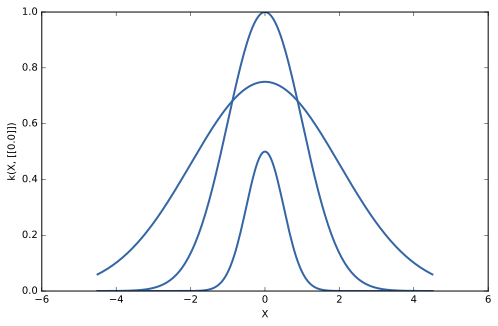

In [5]:
_ = ker1.plot(ax=plt.gca())
_ = ker2.plot(ax=plt.gca())
_ = ker3.plot(ax=plt.gca())

## Implemented kernels

Many kernels are already implemented in GPy. The following figure gives a summary of some of them (a comprehensive list can be list can be found but typing `GPy.kern.<tab>`):

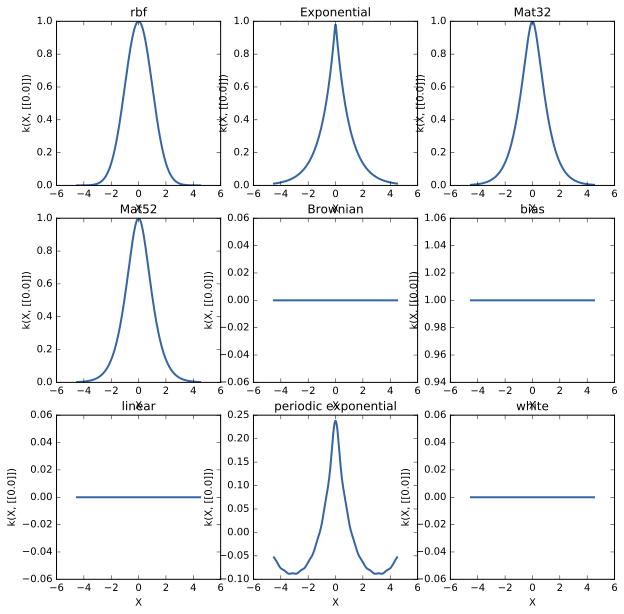

In [7]:
figure, axes = plt.subplots(3,3, figsize=(10,10), tight_layout=False)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), GPy.kern.Matern52(1), GPy.kern.Brownian(1), GPy.kern.Bias(1), GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1)]
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=0)
    a.set_title(k.name.replace('_', ' '))

## Operations to combine kernels

In GPy, kernel objects can be added or multiplied to create a mutlitude of kernel objects. Parameters and their gradients are handled automatically, and so appear in the combined objects. When kernels are used inside GP objects all the necessary graidents are automagically computed using the chain-rule. 

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        
  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /usr/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


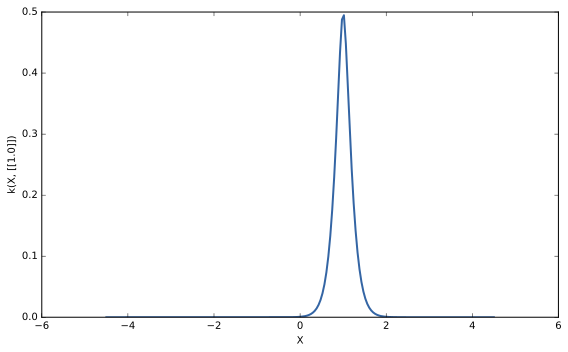

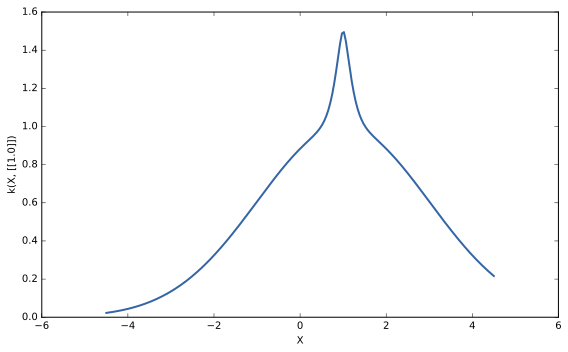

In [19]:
# Product of kernels
k1 = GPy.kern.RBF(1,1.,2.)
k2 = GPy.kern.Matern32(1, 0.5, 0.2)
k_prod = k1 *k2
print (k_prod)
k_prod.plot()



# Sum of kernels
k1 = GPy.kern.RBF(1,1.,2.)
k2 = GPy.kern.Matern32(1, 0.5, 0.2)
k_add = k1 + k2
print (k_add)
k_add.plot()

Note that the kernels that have been added are pythonic in that the objects remain linked: changing parameters of an add kernel changes those of the constituent parts, and vice versa

In [20]:
print (k1, '\n')
k_add.rbf.variance = 12.
print (k1)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |         

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |        


## Operating on different domains

When multiplying and adding kernels, there are two general possibilites, one can assume that the kernels to add/multiply are defined on the same space or on different spaces:

 * a kernel over $\mathbb{R} \times \mathbb{R}: k(x,x') = k_1(x,x') \times k_2(x,x')$
 * a kernel over $\mathbb{R}^2 \times \mathbb{R}^2: k(\mathbf{x},\mathbf{x}') = k_1(x_1,x'_1) \times k_2(x_2,x'_2)$
 
To keep things as general as possible, in GPy kernels are assigned `active_dims` which tell the kernel what to work on. To create a kernel which is a product of krnels on different spaces, we can do

 /usr/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


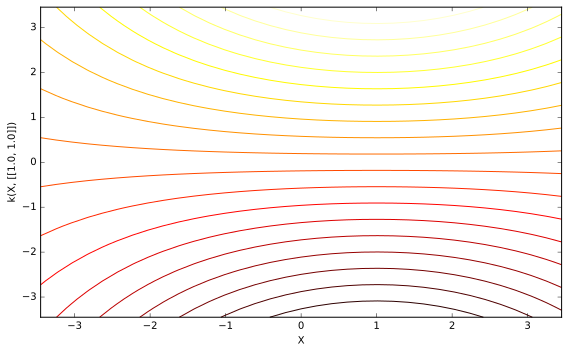

In [21]:
k1 = GPy.kern.Linear(input_dim=1, active_dims=[0]) # works on the first column of X, index=0
k2 = GPy.kern.ExpQuad(input_dim=1, lengthscale=3, active_dims=[1]) # works on the second column of X, index=1
k = k1 * k2
k.plot(x=np.ones((1,2)))

 /usr/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


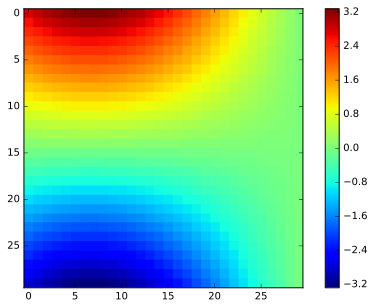

In [22]:
def plot_sample(k):
    xx, yy = np.mgrid[-3:3:30j, -3:3:30j]
    X = np.vstack((xx.flatten(), yy.flatten())).T
    K = k.K(X)
    s = np.random.multivariate_normal(np.zeros(X.shape[0]), K)
    #plt.contourf(xx, yy, s.reshape(*xx.shape), cmap=plt.cm.hot)
    plt.imshow(s.reshape(*xx.shape), interpolation='nearest')
    plt.colorbar()
plot_sample(k)

 /usr/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


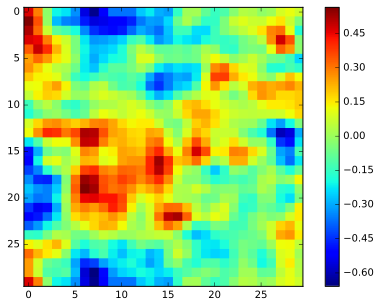

In [23]:
k1 = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[0], period=6, lower=-10, upper=10)# + GPy.kern.Bias(1, variance=0, active_dims=[0])
k2 = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[1], period=8, lower=-10, upper=10)# + GPy.kern.Bias(1, variance=0, active_dims=[0])

#k2 = GPy.kern.ExpQuad(1, active_dims=[1])
k = k1 * k2
plot_sample(k)